# Описание проекта

    Оператор мобильной связи «Мегалайн» выяснил: многие клиенты пользуются архивными тарифами. Они хотят построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».
    В нашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы. Нужно построить модель для задачи классификации, которая выберет подходящий тариф. 
    Построим модель с максимально большим значением accuracy. Нужно довести долю правильных ответов по крайней мере до 0.75. Проверим accuracy на тестовой выборке. А также проверим построенные модели на адекватность
    

# 1. Изучение данных

In [4]:
# Импорт библиотек и данных
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import rc, plot
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 

from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.metrics import roc_curve, classification_report

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

df = pd.read_csv('users_behavior.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [5]:
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [6]:
# Количество клиентов, пользующихся разными тарифами
df['is_ultra'].value_counts()

0    2229
1     985
Name: is_ultra, dtype: int64

## Выводы
1. Имеем таблицу из 3214 объектов и 5 признаков.
2. Для решения задачи выберем целевой признак - 'is_ultra', т.е. будем предсказывать какой тариф будет подходить при определенном наборе остальных признаков. 
3. C учетом того, что целевой признак бинарный будем применять методы бинарной классификации
4. Таблица полная, пропусков нет.
5. Данные не являются полностью сбаланисированными, т.к. целевой признак разделен как 1:2 

# 2. Разбитие данных на выборки

In [7]:
# Разделение данных на на обучающую, валидационную и тестовую выборки в пропорции 3:1:1
train, test = train_test_split(df, test_size=0.2, random_state=42)
train, validate = train_test_split(train, test_size=0.25, random_state=42)

In [8]:
# Проврерка размеров датафреймов
len(train)+len(validate)+len(test)

3214

    Сумма размеров трех полученных датафреймов равна размеру исходных данных

# 3. Исследование моделей


Подготовим переменные для цели и признаков

In [9]:
train_features = train.drop(['is_ultra'], axis=1)
train_target = train['is_ultra'].values
validate_features = validate.drop(['is_ultra'], axis=1)
validate_target = validate['is_ultra'].values
test_features = test.drop(['is_ultra'], axis=1)
test_target = test['is_ultra'].values

## Метод "решающего дерева"

In [10]:
# Обучение модели на тренировочных данных при гипрпарамтрах по умолчанию
model = DecisionTreeClassifier(random_state=43)
model.fit(train_features, train_target)

validate_predictions = model.predict(validate_features)
# Доля правильных ответов для валидационной выборки при параметрах по умолчанию 
print('Accuracy на валидационной выборке:', accuracy_score(validate_target, validate_predictions))

Accuracy на валидационной выборке: 0.7231726283048211


Будем менять значение максимальной глубины дерева в пределах от 1 до 4, учитывая, что количество парметров в модели - 4

In [11]:
best_model = None
best_result = 0
for depth in range(1, 6):
    model = DecisionTreeClassifier(random_state=43, max_depth=depth)
    model.fit(train_features, train_target)
    validate_predictions = model.predict(validate_features)
    result = model.score(validate_features, validate_target) 
    print("max_depth =", depth, ": ", result)
    if result > best_result:
        best_model = model
        best_result = result
        
print("Accuracy наилучшей модели на валидационной выборке:", best_result)


max_depth = 1 :  0.7418351477449455
max_depth = 2 :  0.7744945567651633
max_depth = 3 :  0.7744945567651633
max_depth = 4 :  0.7807153965785381
max_depth = 5 :  0.7713841368584758
Accuracy наилучшей модели на валидационной выборке: 0.7807153965785381


## Метод "случайный лес"

In [12]:
# Обучение модели на тренировочных данных при гипрпарамтрах по умолчанию
model = RandomForestClassifier(random_state=43)
model.fit(train_features, train_target)

validate_predictions = model.predict(validate_features)
# Доля правильных ответов для тестовой выборки при параметрах по умолчанию 
print('Accuracy на валидационной выборке:', accuracy_score(validate_target, validate_predictions))

Accuracy на валидационной выборке: 0.7853810264385692


Будем менять значение числа деревьев в пределах от 1 до 20.

In [13]:
best_model = None
best_result = 0
for est in range(1, 20):
    model = RandomForestClassifier(random_state=43, n_estimators=est) 
    model.fit(train_features, train_target) 
    result = model.score(validate_features, validate_target)
    print("estimators =", est, ": ", result)
    if result > best_result:
        best_model = model 
        best_result = result 
        
print("Accuracy наилучшей модели на валидационной выборке:", best_result)


estimators = 1 :  0.7107309486780715
estimators = 2 :  0.7573872472783826
estimators = 3 :  0.7402799377916018
estimators = 4 :  0.776049766718507
estimators = 5 :  0.7667185069984448
estimators = 6 :  0.7807153965785381
estimators = 7 :  0.7713841368584758
estimators = 8 :  0.7869362363919129
estimators = 9 :  0.7791601866251944
estimators = 10 :  0.7791601866251944
estimators = 11 :  0.7822706065318819
estimators = 12 :  0.7900466562986003
estimators = 13 :  0.7884914463452566
estimators = 14 :  0.7822706065318819
estimators = 15 :  0.7884914463452566
estimators = 16 :  0.7838258164852255
estimators = 17 :  0.7869362363919129
estimators = 18 :  0.7838258164852255
estimators = 19 :  0.7822706065318819
Accuracy наилучшей модели на валидационной выборке: 0.7900466562986003


## Метод "логистическая регрессия"

In [14]:
model = LogisticRegression(random_state=43)
model.fit(train_features, train_target)
result = model.score(validate_features, validate_target)

print("Accuracy на валидационной выборке:", result)

Accuracy на валидационной выборке: 0.7200622083981337


Изменим алгоритм построения модели на более подходящий для небольшого размера данных

In [15]:
model = LogisticRegression(random_state=43, solver='liblinear')
model.fit(train_features, train_target)
result = model.score(validate_features, validate_target)
print("Accuracy модели логистической регрессии на валидационной выборке:", result)

Accuracy модели логистической регрессии на валидационной выборке: 0.7231726283048211


## Выводы
Ни одна из моделей не показала переобучения и недоучения.
Во всех 3 методах моделирования результыты, полученные при значения по умолчанию можно улучшить изменяя гиперпараметры модели.
При использовании моделей на валидационных выборках мы получили следующие результаты **accuracy** :
1. Метод "решающего дерева" - 0,78 (при глубине 4)
2. Метод "случайный лес" - 0,79 (при числе деревьев 12)
3. Метод "логистическая регрессия" - 0,722 (при алгоритме построения "liblinear")

**Наилучшей моделью является "случайный лес" при количестве дереьев 16**

# 4. Исследование наилучшей модели

Проверим качество модели Запустим модели "случайный лес" при количестве дереьев 16 на тестовой выборке

In [16]:
model = RandomForestClassifier(random_state=43, n_estimators=16) 
model.fit(train_features, train_target) 

report = classification_report(test_target, model.predict(test_features), target_names=['Smart', 'Ultra'])
print(report)

              precision    recall  f1-score   support

       Smart       0.83      0.90      0.86       455
       Ultra       0.70      0.54      0.61       188

    accuracy                           0.80       643
   macro avg       0.76      0.72      0.73       643
weighted avg       0.79      0.80      0.79       643



## Выводы
1. Доля правильных ответов - 0.8, что по условиям исследования достаточно.
2. Долю объектов, названных классификатором положительными и при этом действительно являющимися положительными для наибольшего класса - 0.83, что удолетворительно
3. Доля объектов положительного класса из всех объектов положительного класса - 0.9, что хорошо
4. Соотношение классов в тестовой выборке также сохранилось


# 5. Проверка модели на адекватность

Cравним качество модели с качеством константной модели.

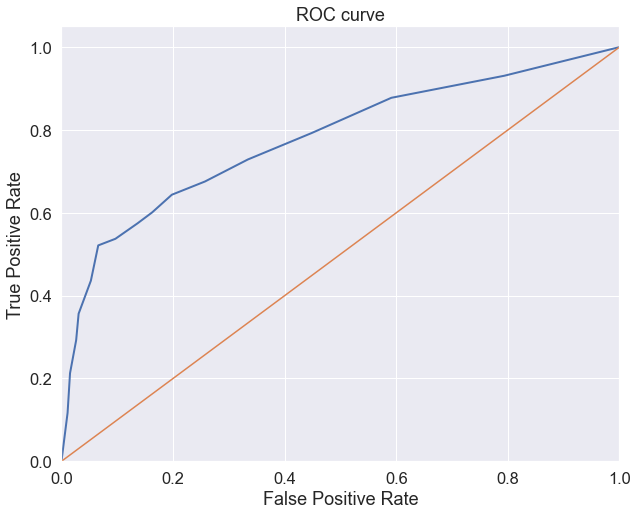

In [17]:
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(10, 8))
fpr, tpr, thresholds = roc_curve(test_target, model.predict_proba(test_features)[:,1], pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

## Выводы 
Модель вменяема и по качеству значительно превосходит константную модель

# Общий вывод

**В ходе исследования предоставленные данные были разделены на 3 датасета : тренировочный, валидационный и тестовый". Были построены 3 модели и была выбрана лучшая по критерию "accuracy". Ей стала модель на основе "Случайного леса" с количеством деревьев 16.
Модель прошла на тестовой выборке проверку на качество и адекватность. Может использоваться для выбора тарифа на основе предпочтений абонента**

